In [36]:
import numpy as np
import modin.pandas as mipd
import math
import os
import time
import json
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx.algorithms import bipartite
from collections import Counter
from scipy.stats import entropy

from matplotlib import pyplot as plt
import seaborn as sns

In [37]:
time_resolution = '2week'
c_path = '../network_data'+time_resolution+'/commits/'
e_path = '../network_data'+time_resolution+'/emails/'

all_graduated_name = np.load('../all_graduated.npy').tolist()
all_graduated = [x.lower() for x in all_graduated_name]
all_retired_name = np.load('../all_retired.npy').tolist()
all_retired = [x.lower() for x in all_retired_name]

In [38]:
print(all_graduated)
print(all_retired)

['uima', 'qpid', 'chukwa', 'easyant', 'drill', 'calcite', 'beehive', 'fineract', 'echarts', 'shiro', 'twill', 'tephra', 'esme', 'ranger', 'tvm', 'tinkerpop', 'daffodil', 'batchee', 'impala', 'falcon', 'apisix', 'thrift', 'tika', 'whirr', 'directmemory', 'kafka', 'allura', 'iotdb', 'rya', 'tuscany', 'activemq', 'jspwiki', 'knox', 'distributedlog', 'hcatalog', 'mynewt', 'airflow', 'etch', 'gobblin', 'tajo', 'trinidad', 'amber', 'cxf', 'airavata', 'devicemap', 'syncope', 'cordova', 'empire-db', 'shindig', 'mnemonic', 'crunch', 'unomi', 'wink', 'hawq', 'isis', 'clerezza', 'vcl', 'buildr', 'asterixdb', 'netbeans', 'stratos', 'iceberg', 'mesos', 'cassandra', 'sis', 'reef', 'tez', 'traffic control', 'stdcxx', 'superset', 'abdera', 'celix', 'geode', 'pinot', 'joshua', 'oodt', 'omid', 'ambari', 'guacamole', 'river', 'ace', 'usergrid', 'myfaces', 'griffin', 'zeppelin', 'helix', 'pdfbox', 'groovy', 'ivy', 'manifoldcf', 'phoenix', 'solr', 'datafu', 'sentry', 'nuvem', 'openoffice.org', 'click', 'vx

#### Get dict
* get_net_dict : means get the net with only module nodes
* get_net_dict_reverse: means get the net with only developer nodes
* get_net_dict_reverse: means get the bipartte net with both module and developer nodes

In [39]:
def get_net_dict(net1):

    if not os.path.exists(net1):
        return None

    net1_dict = {}
    with open(net1, 'r') as f:
        lines = f.read().splitlines()
	# print([net1, net2])
    for line in lines:
        sender, receiver, weight = line.split('##')
        #print(sender)
        #print(receiver)
        if not (sender in net1_dict.keys()):
            net1_dict[sender] = {}
        net1_dict[sender][receiver] = int(weight)
    
    return net1_dict

def get_net_dict_reverse(net1):

    if not os.path.exists(net1):
        return None

    net1_dict = {}
    with open(net1, 'r') as f:
        lines = f.read().splitlines()
	# print([net1, net2])
    for line in lines:
        sender, receiver, weight = line.split('##')
        if not (receiver in net1_dict.keys()):
            net1_dict[receiver] = {}
        if not (sender in net1_dict[receiver].keys()):
            net1_dict[receiver][sender] = int(weight)
        else:
            net1_dict[receiver][sender]+= int(weight)
    
    return net1_dict

def get_net_dict_and_reverse(net1):

    if not os.path.exists(net1):
        return None

    net1_dict = {}
    with open(net1, 'r') as f:
        lines = f.read().splitlines()
	# print([net1, net2])
    for line in lines:
        sender, receiver, weight = line.split('##')
        if not (sender in net1_dict.keys()):
            net1_dict[sender] = {}
        net1_dict[sender][receiver] = int(weight)
        if not (receiver in net1_dict.keys()):
            net1_dict[receiver] = {}
        if not (sender in net1_dict[receiver].keys()):
            net1_dict[receiver][sender] = int(weight)
        else:
            net1_dict[receiver][sender]+= int(weight)
    
    return net1_dict

In [40]:
def get_all_net_dict(the_path, projid):

    all_net_dict = {}
    global time_resolution
    for seq_num in range(0, 150, int(time_resolution[0])):

        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict(this_fname)
        #while os.path.exists(this_fname):
        if this_dict:
            #print(this_dict)
            for key in this_dict.keys():
                #print(key)
                if key in set(all_net_dict.keys()):
                    all_net_dict[key] = dict(Counter(this_dict[key])+Counter(all_net_dict[key]))
                    #print(all_net_dict)
                else:
                    all_net_dict[key] = this_dict[key]
                    #print(all_net_dict)
        else:
            continue
    return all_net_dict

def get_all_net_dict_reverse(the_path, projid):

    all_net_dict = {}
    
    for seq_num in range(0, 150, int(time_resolution[0])):

        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict_reverse(this_fname)
        #while os.path.exists(this_fname):
        if this_dict:
            #print(this_dict)
            for key in this_dict.keys():
                #print(key)
                if key in set(all_net_dict.keys()):
                    all_net_dict[key] = dict(Counter(this_dict[key])+Counter(all_net_dict[key]))
                    #print(all_net_dict)
                else:
                    all_net_dict[key] = this_dict[key]
                    #print(all_net_dict)
        else:
            continue
    return all_net_dict

def get_all_net_dict_andreverse(the_path, projid):

    all_net_dict = {}
    
    for seq_num in range(0, 150, int(time_resolution[0])):

        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict_and_reverse(this_fname)
        #while os.path.exists(this_fname):
        if this_dict:
            #print(this_dict)
            for key in this_dict.keys():
                #print(key)
                if key in set(all_net_dict.keys()):
                    all_net_dict[key] = dict(Counter(this_dict[key])+Counter(all_net_dict[key]))
                    #print(all_net_dict)
                else:
                    all_net_dict[key] = this_dict[key]
                    #print(all_net_dict)
        else:
            continue
    return all_net_dict
    

### Entropy Calculation:
* node_entropy_calc: calculate the entropy of degrees developer or module nodes
* node_entropy_unweighted_calc: calculate the entropy of unweighted degrees of developer or module nodes
* dict_entropy_calc: calculate the entropy of the whole network structure
* dict_entropy_unweighted_calc: calculate the entropy of the whole unweighted network structure

In [41]:
def node_entropy_calc(node_dict):
    if len(node_dict)<=1:
        return 0.0
    probs = np.array(node_dict.values())/sum(node_dict.values())
    entro = entropy(probs.tolist())
    
    return entro

def node_entropy_unweighted_calc(node_dict):
    if len(node_dict)<=1:
        return 0.0
    probs = np.array(node_dict.values())/sum(node_dict.values())
    entro = entropy(probs.tolist())
    
    return entro

def dict_entropy_calc(net_dict):
    if len(net_dict)<=1:
        return 0.0
    entro = 0.0
    counts = []
    sum_all = 0.0
    for sender in net_dict.keys():
        sum_this = sum(net_dict[sender].values())
        sum_all+= sum_this
        counts.append(sum_this) 
        #for receiver in net_dict[sender].keys():
    
    probs = np.array(counts)/sum_all
    entro = entropy(probs.tolist())
    
    emax = math.log(len(counts))
    #emin = math.log(4*(len(counts)-1))/2
    emin = 0

    return (entro-emin)/(emax-emin)

def dict_entropy_unweighted_calc(net_dict):
    if len(net_dict)<=1:
        return 0.0
    entro = 0.0
    counts = []
    sum_all = 0.0
    for sender in net_dict.keys():
        sum_this = len(net_dict[sender].values())
        sum_all+= sum_this
        counts.append(sum_this) 
        #for receiver in net_dict[sender].keys():
    
    probs = np.array(counts)/sum_all
    entro = entropy(probs.tolist())

    emax = math.log(len(counts))
    #emin = math.log(4*(len(counts)-1))/2
    emin = 0

    return (entro-emin)/(emax-emin)

### Calculate of Network Structure Entropy
#### All and Weighted

In [42]:
the_path = c_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_tech_entropy = pd.DataFrame()

all_tech_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict_reverse(the_path, projid)
    #print(proj_dict)
    proj_entropy = dict_entropy_calc(proj_dict)
    proj_series_entropy = []
    #proj_series_entropy.append(proj_entropy)
    
    for seq_num in range(0, 150, int(time_resolution[0])):
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict_reverse(this_fname)
        if this_dict:
            this_entropy = dict_entropy_calc(this_dict)
            proj_series_entropy.append(this_entropy)
        else:
            continue
    for seq_num in range(len(proj_series_entropy), 150, int(time_resolution[0])):
        proj_series_entropy.append(-1.0)
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_tech_entropy[projname] = proj_entropy
    #print(projname)
    df_tech_entropy[projname] = pd.Series(proj_series_entropy)
df_tech_entropy = df_tech_entropy.fillna(-1.0) 
df_tech_entropy.to_csv("./tech_entropy"+time_resolution[0]+".csv", index=None, sep=',')
    

100%|██████████| 265/265 [00:09<00:00, 29.32it/s]


In [43]:
the_path = e_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_social_entropy = pd.DataFrame()

all_social_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict_reverse(the_path, projid)
    #print(proj_dict)
    proj_entropy = dict_entropy_calc(proj_dict)
    proj_series_entropy = []
    #proj_series_entropy.append(proj_entropy)
    
    for seq_num in range(0, 150, int(time_resolution[0])):
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict_reverse(this_fname)
        if this_dict:
            this_entropy = dict_entropy_calc(this_dict)
            proj_series_entropy.append(this_entropy)
        else:
            continue
    for seq_num in range(len(proj_series_entropy), 150, int(time_resolution[0])):
        proj_series_entropy.append(-1.0)
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_social_entropy[projname] = proj_entropy
    #print(projname)
    df_social_entropy[projname] = pd.Series(proj_series_entropy)
df_social_entropy = df_social_entropy.fillna(-1.0)  
df_social_entropy.to_csv("./social_entropy"+time_resolution+".csv", index=None, sep=',')
    

100%|██████████| 274/274 [00:03<00:00, 69.90it/s]


In [44]:
json_str = json.dumps(all_tech_entropy)
with open("./tech_entropy"+time_resolution+".json", 'w') as json_file:
    json_file.write(json_str)

json_str = json.dumps(all_social_entropy)
with open("./social_entropy"+time_resolution+".json", 'w') as json_file:
    json_file.write(json_str)


In [45]:
all_tech_entropy

{'Etch': 0.7469325943217942,
 'Impala': 0.6670608066427418,
 'Shindig': 0.73027808030269,
 'Droids': 0.6776392632327145,
 'NetBeans': 0.37484357294819914,
 'Zeppelin': 0.45520979026529806,
 'Rya': 0.6845721336924654,
 'FreeMarker': 0.1546070978678114,
 'stdcxx': 0.3919125826341825,
 'OpenWhisk': 0.6565142578532219,
 'Wave': 0.37502116187659507,
 'Beam': 0.4824047484400984,
 'Trafodion': 0.517420672896356,
 'Ratis': 0.6059619908289111,
 'REEF': 0.6069953756893082,
 'MRUnit': 0.5085570348716246,
 'OFBiz': 0.6198880467198455,
 'Crunch': 0.3887587812078985,
 'Atlas': 0.6491164679489809,
 'NMaven': 0.5150158075064635,
 'ant': 0.5911459939114385,
 'Kylin': 0.5718803132498922,
 'XAP': 0.4822818783188873,
 'DataSketches': 0.4220862330251375,
 'CouchDB': 0.5566820127397482,
 'AWF': 0.23752820399448268,
 'DeviceMap': 0.7236165683895706,
 'Celix': 0.17671111367552694,
 'Roller': 0.3719088081322565,
 'SINGA': 0.5864011907426613,
 'Ambari': 0.6708253108374923,
 'Guacamole': 0.1799498791932472,
 'HC

In [46]:
all_social_entropy

{'Myriad': 0.736193292308233,
 'Etch': 0.6669834335108061,
 'SINGA': 0.7033221176488413,
 'Impala': 0.6820918414113418,
 'Shindig': 0.6646054247950344,
 'Droids': 0.6830017342336311,
 'NetBeans': 0.638306345729128,
 'Wave': 0.7319922437915594,
 'Shiro': 0.5443779202773165,
 'Zeppelin': 0.6888487325892129,
 'Rya': 0.7103185656201612,
 'FreeMarker': 0.6168404001606077,
 'stdcxx': 0.5078211321206835,
 'OpenWhisk': 0.687005871375287,
 'Beam': 0.7107094929521969,
 'zeta': 0.7143407326778907,
 'Trafodion': 0.7230755849595041,
 'Ratis': 0.7339645204830806,
 'REEF': 0.6840648829736055,
 'MRUnit': 0.7064708444981508,
 'OFBiz': 0.6564463920979876,
 'Crunch': 0.6385977065325351,
 'Atlas': 0.7248835330187988,
 'NMaven': 0.6290773529334241,
 'ant': 0.7784102864137178,
 'oltu': 0.6482720678094748,
 'Kylin': 0.6769092123087984,
 'XAP': 0.7239058836908192,
 'DataSketches': 0.6499303153785968,
 'Wookie': 0.5852923213754028,
 'CouchDB': 0.7113808222461698,
 'AWF': 0.7143173577546726,
 'Any23': 0.6469796

In [47]:
all_g = list()
for x in all_social_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_social_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

In [48]:
df_tech_entropy_whole = pd.DataFrame.from_dict(all_tech_entropy, orient='index')
df_tech_entropy_whole['Graduated'] = pd.Series()
for row in df_tech_entropy_whole.index:
    #print(row)
    if row in all_g:
        df_tech_entropy_whole.loc[row, "Graduated"] = "Graduated"
    elif row in all_r:
        df_tech_entropy_whole.loc[row, "Graduated"] = "Retired"
df_tech_entropy_whole.columns = ["Entropy", "Graduated"]

In [49]:
df_tech_entropy_whole["Graduated"].isnull().describe()

count       265
unique        2
top       False
freq        244
Name: Graduated, dtype: object

In [50]:
df_tech_entropy_whole.dropna()

,Entropy,Graduated
Etch,0.746933,Graduated
Impala,0.667061,Graduated
Shindig,0.730278,Graduated
Droids,0.677639,Retired
NetBeans,0.374844,Graduated
...,...,...
Warble,0.000000,Retired
Concerted,0.923025,Retired
JuiCE,0.000000,Retired
Kabuki,0.000000,Retired


Text(0.5, 1.0, 'Compare Network Entropy : Tech Networks')

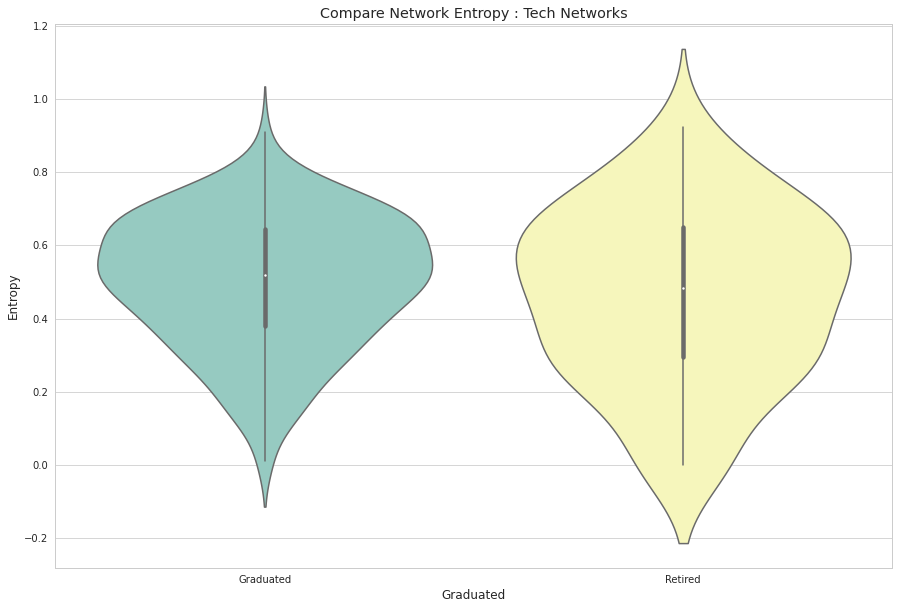

In [51]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="Graduated", y="Entropy",
                    data=df_tech_entropy_whole,
                    scale="width", palette="Set3")
plt.title("Compare Network Entropy : Tech Networks")

Text(0.5, 1.0, 'Compare Network Entropy : Tech Networks')

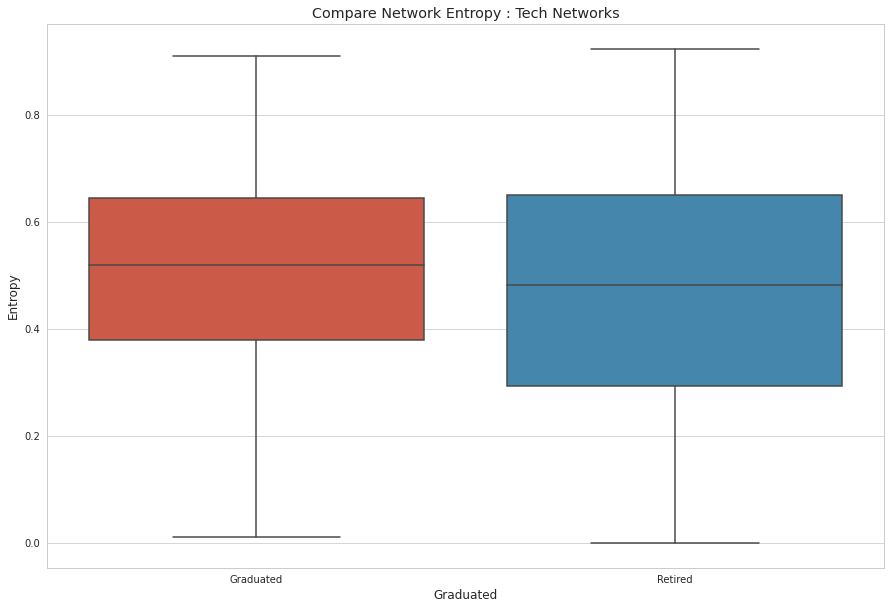

In [52]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
sns.boxplot(x="Graduated", y="Entropy",
                    data=df_tech_entropy_whole)
plt.title("Compare Network Entropy : Tech Networks")

In [53]:
all_g = list()
for x in all_social_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_social_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

In [54]:
df_social_entropy_whole = pd.DataFrame.from_dict(all_social_entropy, orient='index')
df_social_entropy_whole['Graduated'] = pd.Series()
for row in df_social_entropy_whole.index:
    #print(row)
    if row in all_g:
        df_social_entropy_whole.loc[row, "Graduated"] = "Graduated"
    elif row in all_r:
        df_social_entropy_whole.loc[row, "Graduated"] = "Retired"
df_social_entropy_whole.columns = ["Entropy", "Graduated"]

Text(0.5, 1.0, 'Compare Network Entropy : Social Networks')

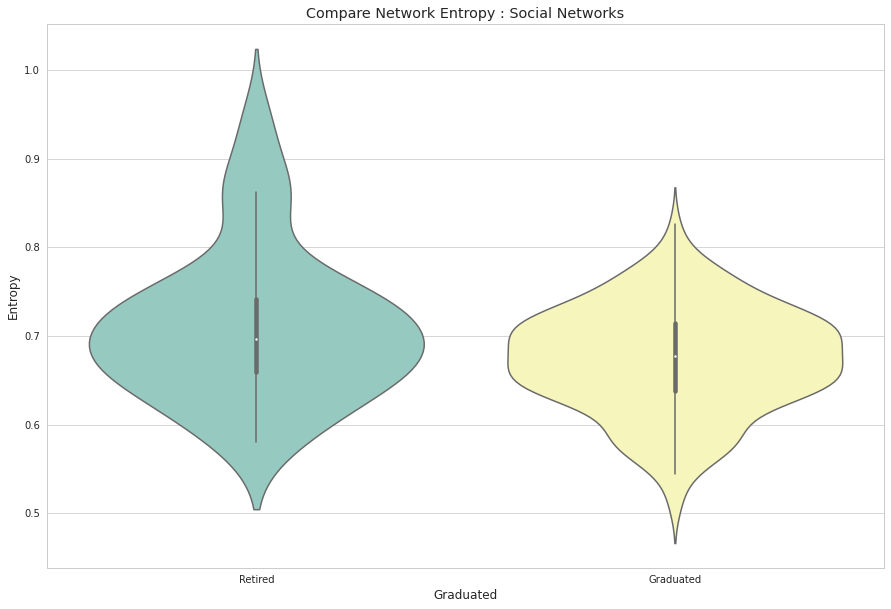

In [55]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="Graduated", y="Entropy",
                    data=df_social_entropy_whole,
                    scale="width", palette="Set3")
plt.title("Compare Network Entropy : Social Networks")

Text(0.5, 1.0, 'Compare Network Entropy : Social Networks')

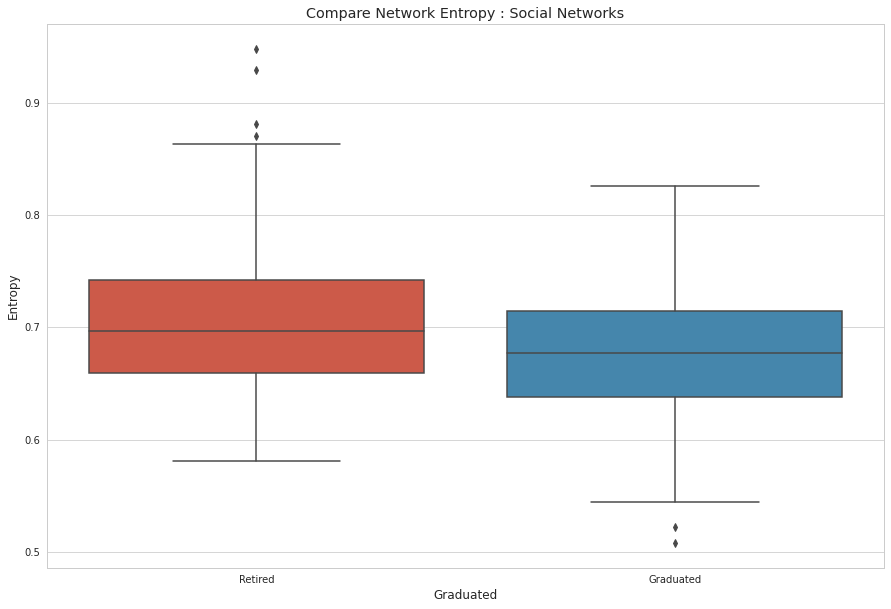

In [56]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
sns.boxplot(x="Graduated", y="Entropy",
                    data=df_social_entropy_whole)
plt.title("Compare Network Entropy : Social Networks")

(0.0, 150.0)

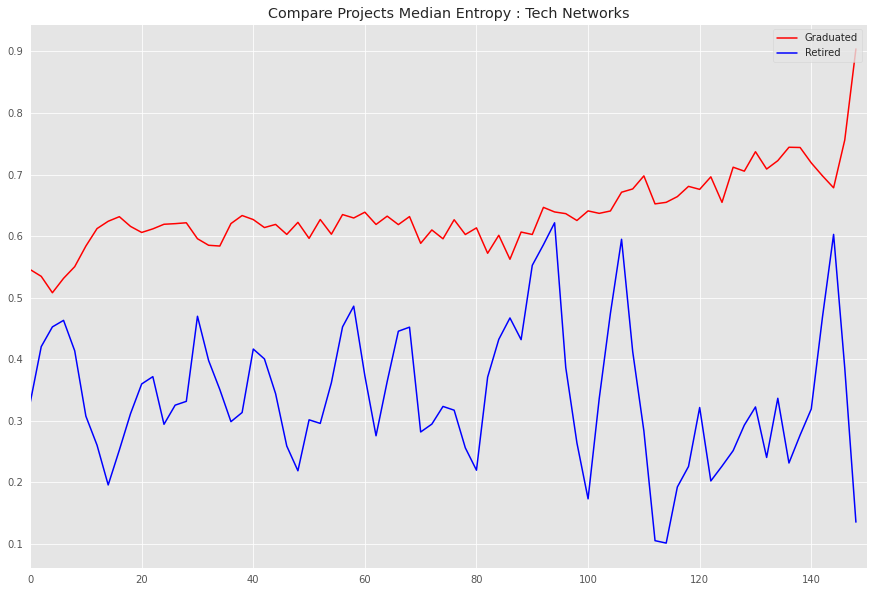

In [57]:
all_g = list()
for x in all_tech_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_tech_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_tech_entropy.index))]
count = [0 for i in range(len(df_tech_entropy.index))]

for col in all_g:
    data = df_tech_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d1 = ave[:j]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

ave = [[] for i in range(len(df_tech_entropy.index))]
count = [0 for i in range(len(df_tech_entropy.index))]

for col in all_r:
    data = df_tech_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d2 = ave[:j]
from scipy.signal import savgol_filter
d2 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median Entropy : Tech Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 150)

(0.0, 150.0)

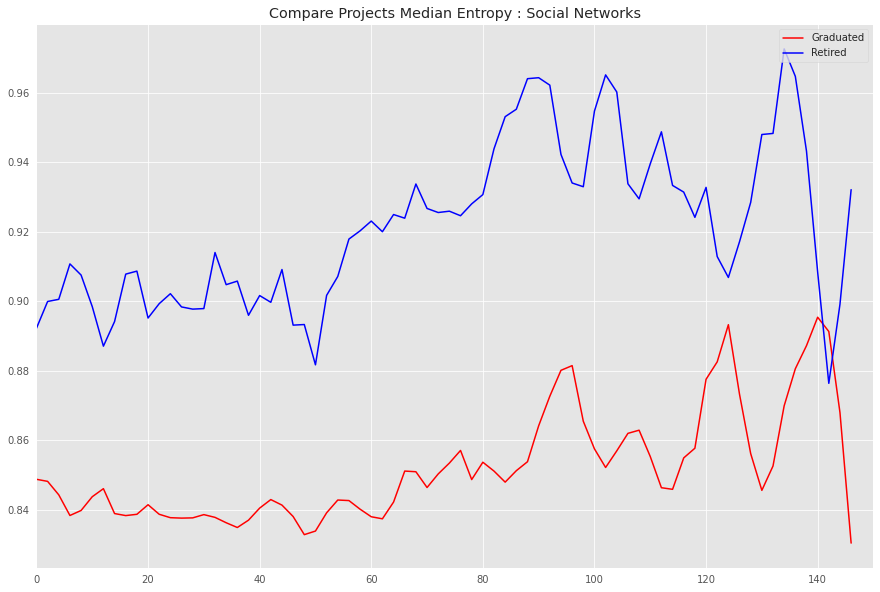

In [58]:
all_g = list()
for x in all_social_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_social_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_social_entropy.index))]
count = [0 for i in range(len(df_social_entropy.index))]

for col in all_g:
    data = df_social_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d1 = ave[:j]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

ave = [[] for i in range(len(df_social_entropy.index))]
count = [0 for i in range(len(df_social_entropy.index))]

for col in all_r:
    data = df_social_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d2 = ave[:j]
from scipy.signal import savgol_filter
d2 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median Entropy : Social Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 150)

In [59]:
len(df_tech_entropy)

95

### Calculate of Network Structure Entropy
#### All and UNWeighted

In [60]:
the_path = c_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_tech_entropy = pd.DataFrame()

all_tech_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict_andreverse(the_path, projid)
    #print(proj_dict)
    proj_entropy = dict_entropy_unweighted_calc(proj_dict)
    proj_series_entropy = []
    #proj_series_entropy.append(proj_entropy)
    
    for seq_num in range(0, 150, int(time_resolution[0])):
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict_and_reverse(this_fname)
        if this_dict:
            this_entropy = dict_entropy_unweighted_calc(this_dict)
            proj_series_entropy.append(this_entropy)
        else:
            continue
    for seq_num in range(len(proj_series_entropy), 150, int(time_resolution[0])):
        proj_series_entropy.append(-1.0)
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_tech_entropy[projname] = proj_entropy
    #print(projname)
    df_tech_entropy[projname] = pd.Series(proj_series_entropy)
df_tech_entropy = df_tech_entropy.fillna(-1.0)   
df_tech_entropy.to_csv("./tech_entropy_unweighted"+time_resolution+".csv", index=None, sep=',')
    

100%|██████████| 265/265 [07:14<00:00,  1.64s/it]


In [61]:
the_path = e_path
projects = os.listdir(the_path)
project_names = [x.split('__')[0] for x in projects]
project_freqs = pd.Series(project_names)
project_names = project_freqs.drop_duplicates().values

df_social_entropy = pd.DataFrame()

all_social_entropy = {}
for projid in tqdm(project_names):
    proj_dict = get_all_net_dict_andreverse(the_path, projid)
    #print(proj_dict)
    proj_entropy = dict_entropy_unweighted_calc(proj_dict)
    proj_series_entropy = []
    #proj_series_entropy.append(proj_entropy)
    
    for seq_num in range(0, 150, int(time_resolution[0])):
        this_fname = the_path+projid+'__'+str(seq_num).zfill(3)+".edgelist"
        this_dict = get_net_dict_and_reverse(this_fname)
        if this_dict:
            this_entropy = dict_entropy_unweighted_calc(this_dict)
            proj_series_entropy.append(this_entropy)
        else:
            continue
    for seq_num in range(len(proj_series_entropy), 150, int(time_resolution[0])):
        proj_series_entropy.append(-1.0)
    projname = projid
    for name in all_graduated_name:
        if name.lower() == projid:    
            projname = name
            break
    for name in all_retired_name:
        if name.lower() == projid:    
            projname = name
            break
    all_social_entropy[projname] = proj_entropy
    #print(projname)
    df_social_entropy[projname] = pd.Series(proj_series_entropy)
df_social_entropy = df_social_entropy.fillna(-1.0)   
df_social_entropy.to_csv("./social_entropy_unweighted"+time_resolution[0]+".csv", index=None, sep=',')
    

100%|██████████| 274/274 [00:04<00:00, 65.96it/s]


In [62]:
json_str = json.dumps(all_tech_entropy)
with open("./tech_entropy_unweighted"+time_resolution+".json", 'w') as json_file:
    json_file.write(json_str)

json_str = json.dumps(all_social_entropy)
with open("./social_entropy_unweighted"+time_resolution+".json", 'w') as json_file:
    json_file.write(json_str)


In [63]:
all_g = list()
for x in all_tech_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_tech_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

In [64]:
df_tech_entropy_whole = pd.DataFrame.from_dict(all_tech_entropy, orient='index')
df_tech_entropy_whole['Graduated'] = pd.Series()
for row in df_tech_entropy_whole.index:
    #print(row)
    if row in all_g:
        df_tech_entropy_whole.loc[row, "Graduated"] = "Graduated"
    elif row in all_r:
        df_tech_entropy_whole.loc[row, "Graduated"] = "Retired"
df_tech_entropy_whole.columns = ["Entropy", "Graduated"]

Text(0.5, 1.0, 'Compare Network Entropy : Unweighted Tech Networks')

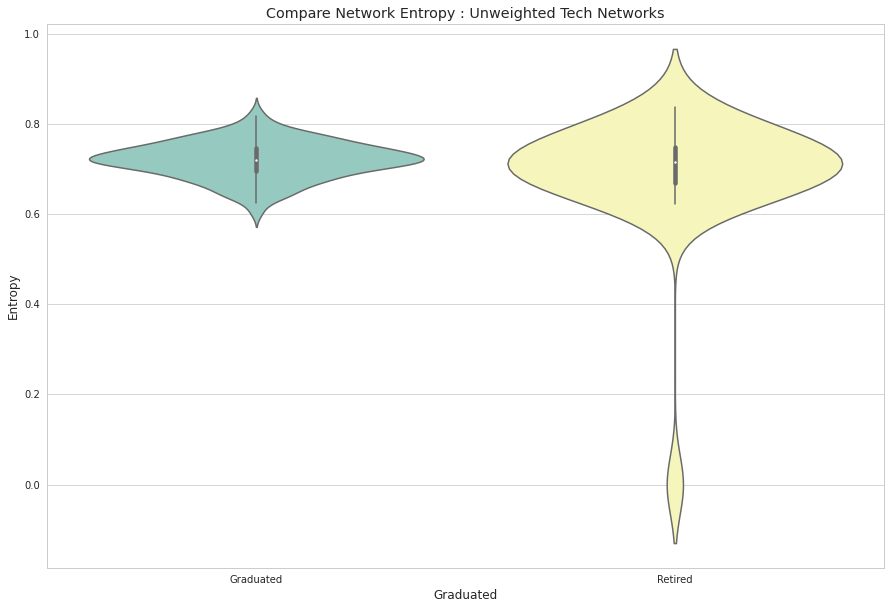

In [65]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="Graduated", y="Entropy",
                    data=df_tech_entropy_whole,
                    scale="width", palette="Set3")
plt.title("Compare Network Entropy : Unweighted Tech Networks")

In [66]:
all_g = list()
for x in all_social_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_social_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

In [67]:
df_social_entropy_whole = pd.DataFrame.from_dict(all_social_entropy, orient='index')
df_social_entropy_whole['Graduated'] = pd.Series()
for row in df_social_entropy_whole.index:
    #print(row)
    if row in all_g:
        df_social_entropy_whole.loc[row, "Graduated"] = "Graduated"
    elif row in all_r:
        df_social_entropy_whole.loc[row, "Graduated"] = "Retired"
df_social_entropy_whole.columns = ["Entropy", "Graduated"]

Text(0.5, 1.0, 'Compare Network Entropy : Unweighted Social Networks')

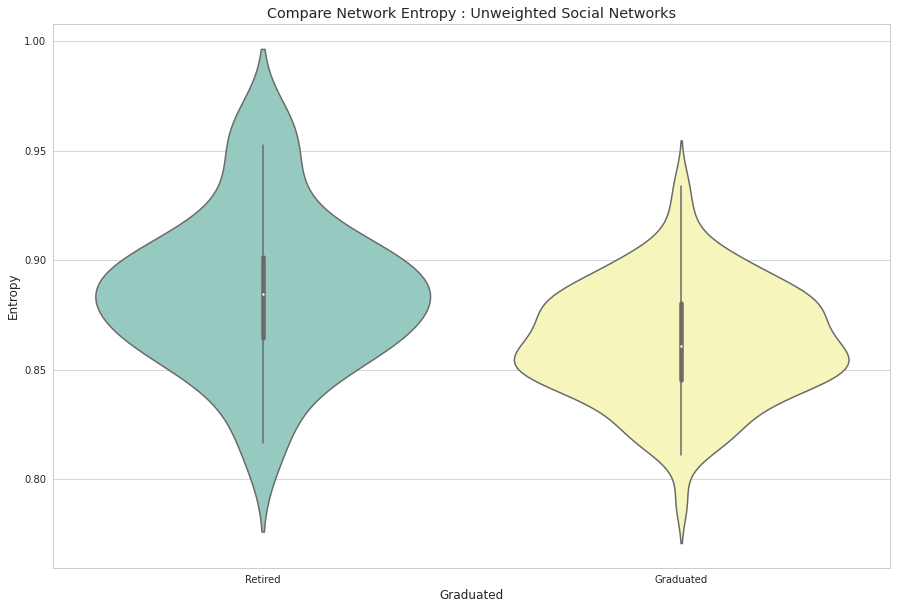

In [68]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))

ax = sns.violinplot(x="Graduated", y="Entropy",
                    data=df_social_entropy_whole,
                    scale="width", palette="Set3")
plt.title("Compare Network Entropy : Unweighted Social Networks")

(0.0, 150.0)

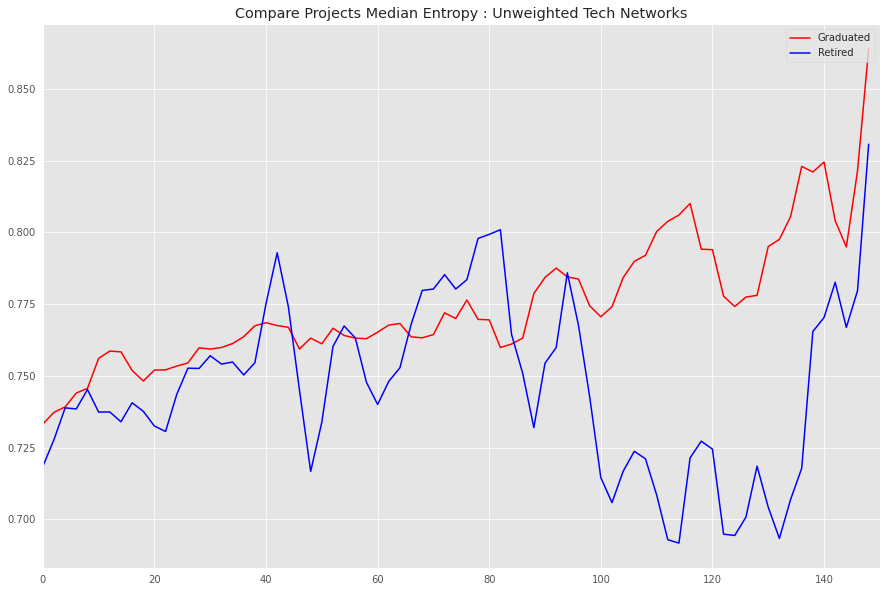

In [69]:
all_g = list()
for x in all_tech_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_tech_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_tech_entropy.index))]
count = [0 for i in range(len(df_tech_entropy.index))]

for col in all_g:
    data = df_tech_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d1 = ave[:j]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

ave = [[] for i in range(len(df_tech_entropy.index))]
count = [0 for i in range(len(df_tech_entropy.index))]

for col in all_r:
    data = df_tech_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d2 = ave[:j]
from scipy.signal import savgol_filter
d2 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median Entropy : Unweighted Tech Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 150)

(0.0, 150.0)

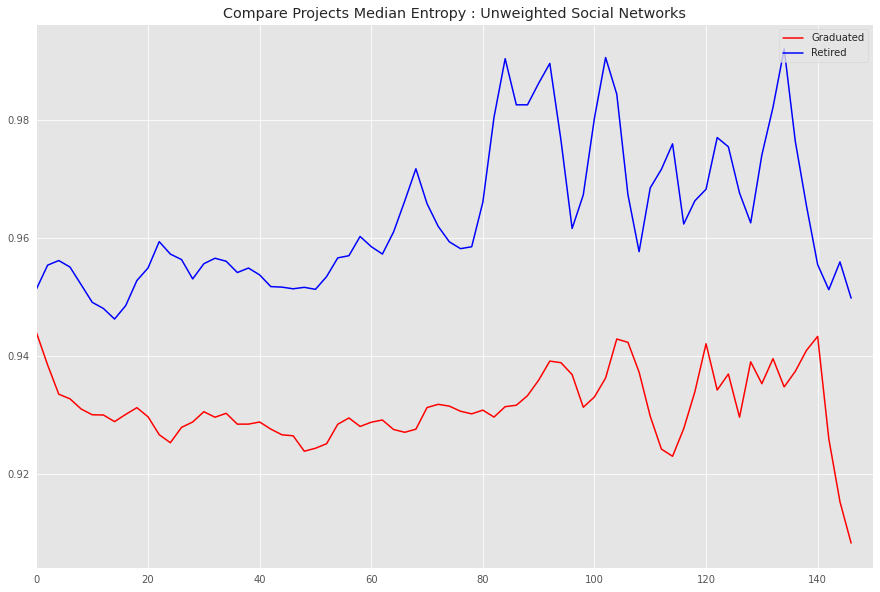

In [70]:
all_g = list()
for x in all_social_entropy.keys():
    if x in all_graduated:
        all_g.append(x)
    elif x.lower() in all_graduated:
        all_g.append(x)

all_r = list()
for x in all_social_entropy.keys():
    if x in all_retired:
        all_r.append(x)
    elif x.lower() in all_retired:
        all_r.append(x)

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

ave = [[] for i in range(len(df_social_entropy.index))]
count = [0 for i in range(len(df_social_entropy.index))]

for col in all_g:
    data = df_social_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d1 = ave[:j]
from scipy.signal import savgol_filter
d1 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d1,color = 'r', label = "Graduated")

ave = [[] for i in range(len(df_social_entropy.index))]
count = [0 for i in range(len(df_social_entropy.index))]

for col in all_r:
    data = df_social_entropy[col].values.tolist()
    flag = False
    for i in range(len(data)):
        if data[i]==-1.0 :
            break
        ave[i].append(data[i])
        count[i]+=1
for j in range(len(ave)):
    if count[j]==0:
        break
    ave[j]= np.median(ave[j])

x = [x*int(time_resolution[0]) for x in range(len(ave[:j]))]
d2 = ave[:j]
from scipy.signal import savgol_filter
d2 = savgol_filter(ave[:j], 3, 1)

plt.plot(x,d2,color = 'b', label = 'Retired')
plt.title("Compare Projects Median Entropy : Unweighted Social Networks")

#print(ave)
#print(count)
#plt.bar(x,np.array(count[:i])/len(all_graduated)/10, fc='b', alpha=0.3)
plt.legend(loc='upper right')
plt.xlim(0, 150)